In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

data = yf.download("GOOGL" , start = "2019-01-01" , interval = '1d')
data.head()



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,51.360001,53.039501,51.264000,52.734001,52.734001,31868000
2019-01-03,52.533501,53.313000,51.118500,51.273499,51.273499,41960000
2019-01-04,52.127998,54.000000,51.842999,53.903500,53.903500,46022000
2019-01-07,54.048500,54.134998,53.132000,53.796001,53.796001,47446000
2019-01-08,54.299999,54.667500,53.417500,54.268501,54.268501,35414000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2019-01-02 to 2024-03-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1304 non-null   float64
 1   High       1304 non-null   float64
 2   Low        1304 non-null   float64
 3   Close      1304 non-null   float64
 4   Adj Close  1304 non-null   float64
 5   Volume     1304 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 71.3 KB


In [ ]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce')
data.isnull().sum().sum()


0

In [ ]:
data["Close"]=pd.to_numeric (data.Close,errors='coerce')

In [ ]:
data.isnull().sum().sum()

0

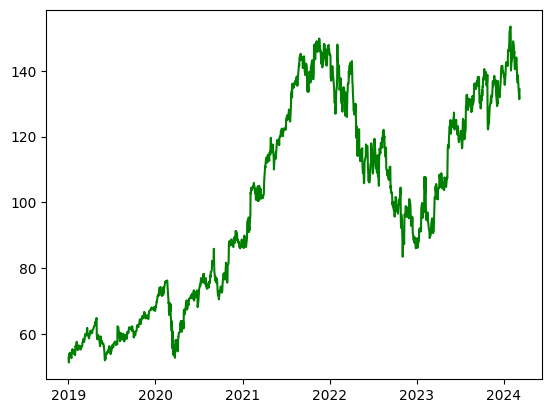

In [ ]:
plt.plot(data.index, data['Close'], color='green', label='Close')
plt.show()

In [ ]:
dataV1 = data.iloc[:,3:4]
dataV1 = dataV1.values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler(feature_range=(0,1))
dataV1 = Scaler.fit_transform(dataV1)


In [ ]:
feature_length = 100

In [ ]:
# Function to create x and y data
def Create_Features_and_Targets(data, feature_length):
  X = list()
  Y = list()
  for i in range(len(data) - feature_length -1):
    X.append(data[i:(i + feature_length), 0])
    Y.append(data[i + feature_length, 0])
  X = np.array(X)
  Y = np.array(Y)
  return X,Y
# calling the function
X_train,y_train= Create_Features_and_Targets(dataV1,feature_length)

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape, y_train.shape


((1203, 100, 1), (1203,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM

In [ ]:
# model
model = Sequential([
   LSTM(100,return_sequences=True,input_shape=(X_train.shape[1],1)),
   Dropout(0.3),
   LSTM(100, return_sequences = False),
   Dropout(0.3),

   Dense(1),
])
model.compile(optimizer='adam',loss="mean_squared_error")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model
history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose=1,
)

Epoch 1/100
101/101 [==============================] - 15s 100ms/step - loss: 0.0135
Epoch 2/100
101/101 [==============================] - 10s 98ms/step - loss: 0.0044
Epoch 3/100
101/101 [==============================] - 10s 99ms/step - loss: 0.0049
Epoch 4/100
101/101 [==============================] - 10s 98ms/step - loss: 0.0046
Epoch 5/100
101/101 [==============================] - 9s 93ms/step - loss: 0.0042
Epoch 6/100
101/101 [==============================] - 9s 92ms/step - loss: 0.0037
Epoch 7/100
101/101 [==============================] - 11s 108ms/step - loss: 0.0033
Epoch 8/100
101/101 [==============================] - 10s 98ms/step - loss: 0.0034
Epoch 9/100
101/101 [==============================] - 11s 109ms/step - loss: 0.0036
Epoch 10/100
101/101 [==============================] - 14s 141ms/step - loss: 0.0031
Epoch 11/100
101/101 [==============================] - 10s 99ms/step - loss: 0.0031
Epoch 12/100
101/101 [==============================] - 11s 112ms/step -

In [ ]:
testData = data.iloc[:,3:4] # Get 'Close' feature
y_real=testData.iloc[feature_length+1:,0:].values #Actual values
x_test = testData.iloc[:,0:].values # data to test
# normalizing the Data using Scaler.transform function
x_test = Scaler.transform(x_test)
x_test, y_test = Create_Features_and_Targets(x_test, feature_length)
# Making data 3 dimensional
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
y_pred = model.predict(x_test)
predicted_price = Scaler.inverse_transform(y_pred)


38/38 [==============================] - 3s 49ms/step


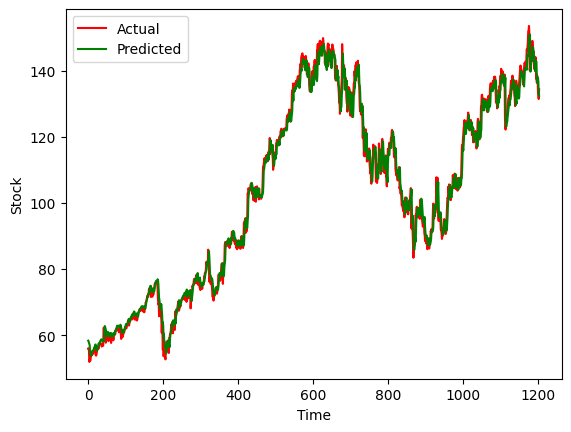

In [ ]:
plt.plot(y_real, color = 'red', label = 'Actual')
plt.plot(predicted_price, color = 'green', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Stock')
plt.legend()
plt.show()

In [ ]:
def predict_given_date(data, date, feature_length):
  if date not in data.index:
     data.loc[pd.Timestamp(date)] = 0
  idx = data.index.get_loc(date)
  close_col = data.iloc[:,3:4]
  close_col = close_col.iloc[idx - feature_length : idx,:].values
  close_col = np.expand_dims(Scaler.transform(close_col) , axis = 0)
  Prediction = model.predict(close_col)
  Prediction = Scaler.inverse_transform(Prediction)
  return Prediction
# calling the function
predict_given_date(data, '2024-03-06', feature_length)


1/1 [==============================] - 0s 42ms/step


array([[132.38777]], dtype=float32)

In [ ]:
# only gives the dates that already exists in the dataset
l = data.index.get_loc('2024-03-07')
data.iloc[l: l+1,:]['Close']
# well we can see the predicted value is very close

Date
2024-03-07    134.380005
Name: Close, dtype: float64